In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze
import torchattacks
from torch.utils.data import TensorDataset, DataLoader
from carla import Data
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import List

from carla import MLModel
from carla import Data
from carla.models.api import MLModel
from carla.recourse_methods.api import RecourseMethod
from carla.evaluation.distances import get_distances

from carla.models.catalog import MLModelCatalog
from carla.data.catalog import OnlineCatalog

import torch.nn as nn
from torch.nn.functional import normalize

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


# Constrained-- Adult


## Actionable Recourse


In [2]:
data_name = "adult"
ds= OnlineCatalog(data_name)

In [3]:
# Model Definition & Load
    
nat_model_carla = MLModelCatalog(ds, "ann", backend='pytorch')
adv_model_carla = MLModelCatalog(ds, "ann", backend='pytorch')


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:591: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


In [4]:
# Load Generated Counterfactuals
factuals = ds.df[:500]
counterfactuals_1 = pd.read_csv('data_artifacts/adult/growing_spheres/gs_cfs_natural_model_adult.csv').drop('Unnamed: 0', axis=1)
counterfactuals_2 = pd.read_csv('data_artifacts/adult/growing_spheres/gs_cfs_adv_model_adult.csv').drop('Unnamed: 0', axis=1)


### Success Rate

In [5]:
print('Success Rate of Naturally Trained Model (Growing Spheres, Fashion): {}'.format(min(1, sum(counterfactuals_1['age'].notnull())/(factuals.shape[0]-sum(factuals['income']==1)))))
print('Success Rate of Adversarially Trained Model (Growing Spheres, Fashion): {}'.format(min(1, sum(counterfactuals_2['age'].notnull())/(factuals.shape[0]-sum(factuals['income']==1)))))


Success Rate of Naturally Trained Model (Growing Spheres, Fashion): 1
Success Rate of Adversarially Trained Model (Growing Spheres, Fashion): 1


### Distance From Original Point

In [6]:
def dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
            
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        distances.append(get_distances(row_copy, original)[0][dist_type])
    return distances

dist_1 = dist(ds, counterfactuals_1, nat_model_carla)
dist_2 = dist(ds, counterfactuals_2, adv_model_carla)


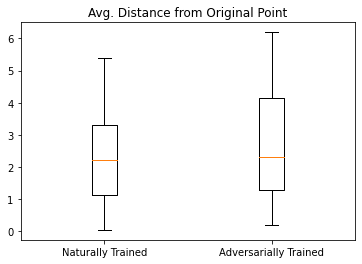

In [7]:
plt.figure()
plt.boxplot([[val for val in dist_1 if not pd.isnull(val)], [val for val in dist_2 if not pd.isnull(val)]])
plt.title('Avg. Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()



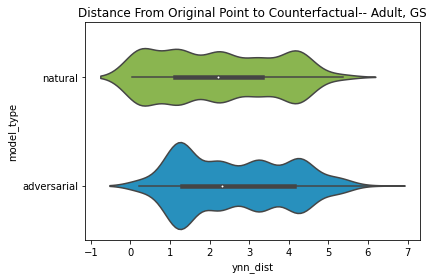

In [9]:
import seaborn as sns
thing = ['natural']*len([val for val in dist_1 if not pd.isnull(val)])+['adversarial']*len([val for val in dist_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in dist_1 if not pd.isnull(val)] + [val for val in dist_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Distance From Original Point to Counterfactual-- Adult, GS')


### Distance to Positive Manifold

In [10]:
def yNN_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    y: int = 5,
    dist_type: int =1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=y).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(factuals.df.iloc[i].values.reshape((1,-1)), 1, return_distance=False)[0]
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        neighbour = positive_class.iloc[knn[0]]
        neighbour = neighbour.drop(mlmodel.data.target)
        neighbour = neighbour.values.reshape((1, -1))
        distance_original_to_closest_pos = get_distances(original, neighbour)[0][dist_type]
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), y, return_distance=False)[0]
        distances_local = 0
        
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            neighbour = neighbour.values.reshape((1, -1))
            row_copy = row.drop(mlmodel.data.target)
            row_copy = row_copy.values.reshape((1, -1))
            
            distances_local += get_distances(row_copy, neighbour)[0][dist_type]
        distances.append((1 / y) * distances_local)
    return distances

def sphere_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    sphere_factor: float = 0.8,
    dist_type: int = 2,
)-> List[List[float]]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        all_deltas = np.asarray(factuals.df.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        all_dists = np.sum(np.square(np.abs(all_deltas)), axis=1, dtype=np.float)
        all_euc_dist = np.sqrt(all_dists)
        radius = np.mean(all_euc_dist)*sphere_factor

        pos_deltas = np.asarray(positive_class.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        pos_dists = np.sum(np.square(np.abs(pos_deltas)), axis=1, dtype=np.float)
        pos_euc_dist = np.sqrt(pos_dists)
        relevant_neighbors = np.where(pos_euc_dist < radius)[0]
        #print(relevant_neighbors)
        if len(relevant_neighbors) == 0:
            distances.append(np.nan)
        else:
            relevant_distances = pos_euc_dist[relevant_neighbors]
            distances.append(np.mean(relevant_distances))
        
    return distances


In [11]:
ynn_1 = yNN_manifold(ds, counterfactuals_1, nat_model_carla)
ynn_2 = yNN_manifold(ds, counterfactuals_2, adv_model_carla)

sphere_1 = sphere_manifold(ds, counterfactuals_1, nat_model_carla)
sphere_2 = sphere_manifold(ds, counterfactuals_2, adv_model_carla)

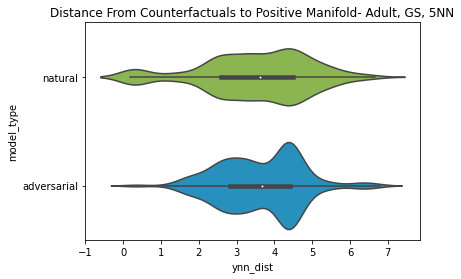

In [12]:
thing = ['natural']*len([val for val in ynn_1 if not pd.isnull(val)])+['adversarial']*len([val for val in ynn_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in ynn_1 if not pd.isnull(val)] + [val for val in ynn_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Distance From Counterfactuals to Positive Manifold- Adult, GS, 5NN')


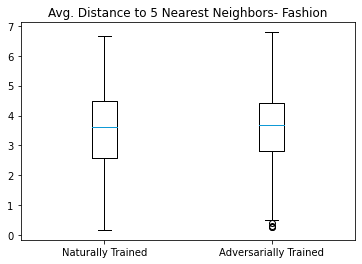

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([[val for val in ynn_1 if not pd.isnull(val)], [val for val in ynn_2 if not pd.isnull(val)]])
plt.title('Avg. Distance to 5 Nearest Neighbors- Fashion')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

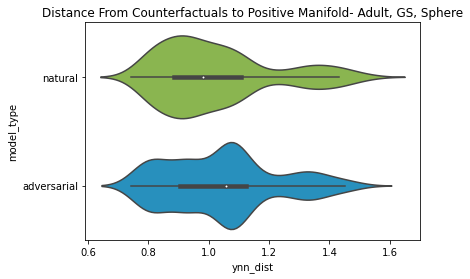

In [14]:
thing = ['natural']*len([val for val in sphere_1 if not pd.isnull(val)])+['adversarial']*len([val for val in sphere_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in sphere_1 if not pd.isnull(val)] + [val for val in sphere_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Distance From Counterfactuals to Positive Manifold- Adult, GS, Sphere')


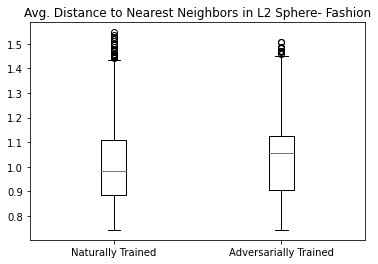

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([[val for val in sphere_1 if not pd.isnull(val)], [val for val in sphere_2 if not pd.isnull(val)]])
plt.title('Avg. Distance to Nearest Neighbors in L2 Sphere- Fashion')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

### Normalized Distance from Original Point

In [16]:
def norm_dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]
    
    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(positive_class.values)
    

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(factuals.df.iloc[i].values.reshape((1,-1)), 1, return_distance=False)[0]
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        neighbour = positive_class.iloc[knn[0]]
        neighbour = neighbour.drop(mlmodel.data.target)
        neighbour = neighbour.values.reshape((1, -1))
        
        distance_original_to_closest_pos = get_distances(original, neighbour)[0][dist_type]
        
            
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        
        distance_cf_to_original = get_distances(row_copy, original)[0][dist_type]
        
        distances.append(distance_cf_to_original/distance_original_to_closest_pos)
    return distances

norm_dist_1 = norm_dist(ds, counterfactuals_1, nat_model_carla)
norm_dist_2 = norm_dist(ds, counterfactuals_2, adv_model_carla)

ZeroDivisionError: float division by zero

In [ ]:
plt.figure()
plt.boxplot([[val for val in norm_dist_1 if not pd.isnull(val)], [val for val in norm_dist_2 if not pd.isnull(val)]])
plt.title('Avg. Normalized Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

### Plotting Normalized Distance From Original vs. Manifold Proximity

Text(0, 0.5, 'Proximity to Positive Manifold')

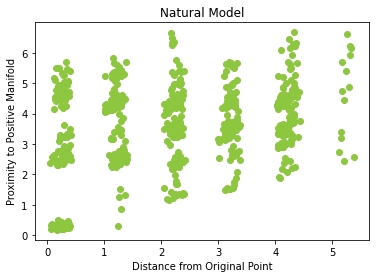

In [17]:
plt.scatter(dist_1, ynn_1)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


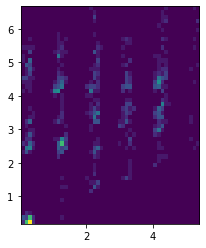

In [18]:
x = [val for val in dist_1 if not pd.isnull(val)]
y = [val for val in ynn_1 if not pd.isnull(val)]
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Text(0, 0.5, 'Proximity to Positive Manifold')

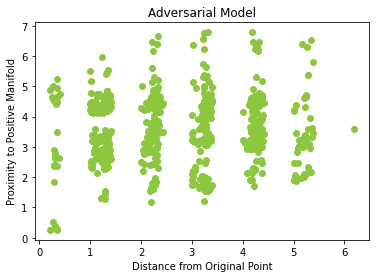

In [19]:
plt.scatter(dist_2, ynn_2)
plt.title('Adversarial Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


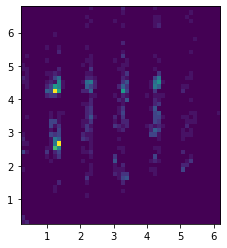

In [20]:
x = [val for val in dist_2 if not pd.isnull(val)]
y = [val for val in ynn_2 if not pd.isnull(val)]
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

### Connectedness

In [21]:
con_ar_1 = pd.read_csv('data_artifacts/adult/growing_spheres/connectedness_natural_adult_gs.csv').drop('Unnamed: 0', axis=1)
con_ar_2 = pd.read_csv('data_artifacts/adult/growing_spheres/connectedness_adv_adult_gs.csv').drop('Unnamed: 0', axis=1)


In [22]:
con_ar_1 = [val for val in con_ar_1.values if not pd.isnull(val)]
con_ar_2 = [val for val in con_ar_2.values if not pd.isnull(val)]

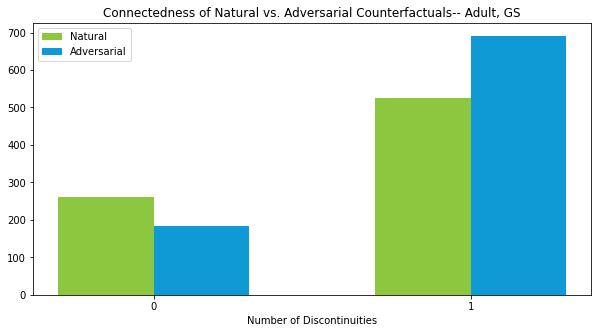

In [23]:
# Numbers of pairs of bars you want
N = 2

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (sum([1 if val == 0 else 0 for val in con_ar_1]), sum([1 if val > 0 else 0 for val in con_ar_1]))
# Specify the values of orange bars (height)
orange_bar = (sum([1 if val == 0 else 0 for val in con_ar_2]), sum([1 if val >0 else 0 for val in con_ar_2]))

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Natural')
plt.bar(ind + width, orange_bar, width, label='Adversarial')

plt.xlabel('Number of Discontinuities')
plt.title('Connectedness of Natural vs. Adversarial Counterfactuals-- Adult, GS')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('0', '1'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

## Actionable Recourse

### Success Rate

### Distance From Original Point

### Normalized Distance from Original Point

### Distance to Positive Manifold

### Continuity